<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/Sequence_to_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ООО "Университет Цифровых Технологий платформа 3"

##Sequence-to-sequence модели (seq2seq)

Sequence-to-sequence модель – это модель, принимающая на вход последовательность элементов (слов, букв, признаков изображения и т.д.) и возвращающая другую последовательность элементов.

Sequence-to-sequence модели (seq2seq) – это модели глубокого обучения, достигшие больших успехов в таких задачах, как машинный перевод, суммаризация текста, аннотация изображений и др. Так, например, в конце 2016 года подобная модель была встроена в Google Translate. Основы же seq2seq моделей были заложены еще в 2014 году с выходом двух статей — Sutskever et al., 2014, Cho et al., 2014.

Обученная модель работает следующим образом:



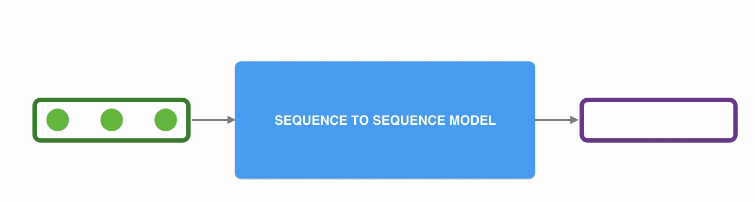

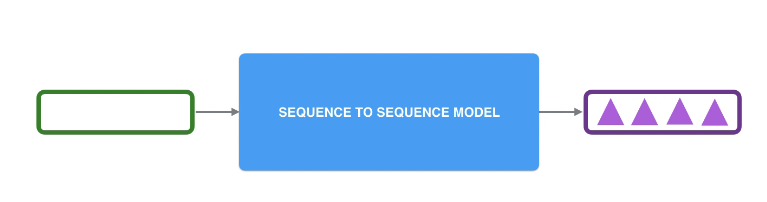

Модель состоит из кодировщика и декодировщика.

Кодер (энкодер) обрабатывает каждый элемент входной последовательности, переводит полученную информацию в вектор, называемый контекстом (context). После обработки всей входной последовательности кодер пересылает контекст декодеру, который затем начинает генерировать выходную последовательность элемент за элементом.

Графически модель можно представить следующим образом:

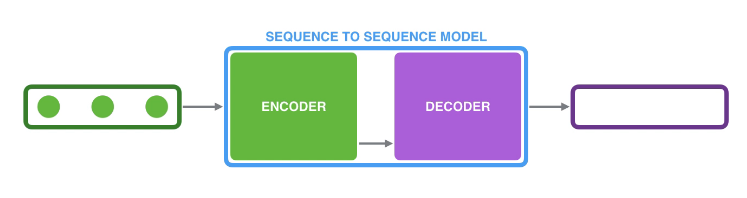

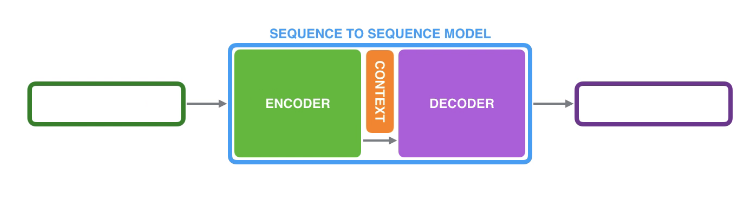

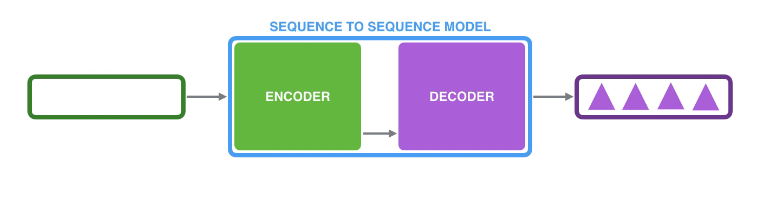

Применительно к нашему примеру контекст представляет собой вектор (массив чисел), а кодер и декодер, в свою очередь, чаще всего являются рекуррентными нейронными сетями.

Контекст – это вектор чисел с плавающей точкой.При обучении модели можно задать размер контекстного вектора – число скрытых нейронов (hidden units) в энкодере RNN.
LSTM — популярная архитектура рекуррентной сети.

По умолчанию в каждый временной отрезок RNN принимает на вход два элемента: непосредственно входной элемент (в случае энкодера, одно слово из исходного предложения) и скрытое состояние (hidden state). Слово, однако, должно быть представлено вектором. 

Для преобразования слов во входные вектора используется так называемая матрица представлений (embedding matrix). Количество строк этой матрицы равно размеру
словаря, а число столбцов — размеру ячейки LSTM. Каждая строка соответствует
векторному представлению соответствующего слова. Каждое слово перед подачей на
вход LSTM сети заменяется на соответствующую строку матрицы представлений. 



###Рассмотрим подробнее на примере модели вопросов-ответов.

Encoder (кодировщик):

- На модель подается последовательность, например, слов в предложении (вопрос, в нашем примере) — seq.
- Предложения токенизируется, для перевода слов в предложении, в последовательность индексов из построенного токенизатором словаря.
- Учитывая тот факт, что длина предложений разная. Находится максимальное по длине предложение и с помощью pad_sequences все предложения выравниваются по длине добавлением 0-ей. В модели используется свойство mask_zero = True, чтобы сказать сети игнорировать пропуски.
- Слова в последовательности преобразуются в пространство векторов (embedding). Преобразования проводяться в самой модели или  используються предобученный embedding.
- У рекуррентной сети, используемой в модели (LSTM или GRU) используется свойство return_state = True, чтобы на выходе получить сжатое представление поданного слова (context) в виде двух векторов состояний h и c.

Decoder (декодер):

- Принимает на вход состояние (context) с encoder-а через параметр initial_state рекуррентной сети.
- Последовательность в которую происходит преобразование дополняется специальными тегами:
 - Начало последовательности подаваемой на вход декодера в начале дополняется тегами \<start> и \<end>.
 - Конец последовательности подаваемой на выход декодера в конце дополняется тегом \<end>.
- Последовательность дополненная тегами \<start> и \<end> преобразуется в пространство векторов с помощью embedding и подается на вход декодера.
- Последовательность индексов дополненная индексом тега \<end> подается на выход декодера (dense слой) без преобразования в embedding. Модель обучается категоризации, т.е. выдавать индекс слова из словаря с некоторой вероятностью.В качестве активационной функции используется activation=’softmax’, а в качестве функции потерь  loss=’sparse_categorical_crossentropy’.
- Encoder и decoder обучаются в общей модели.

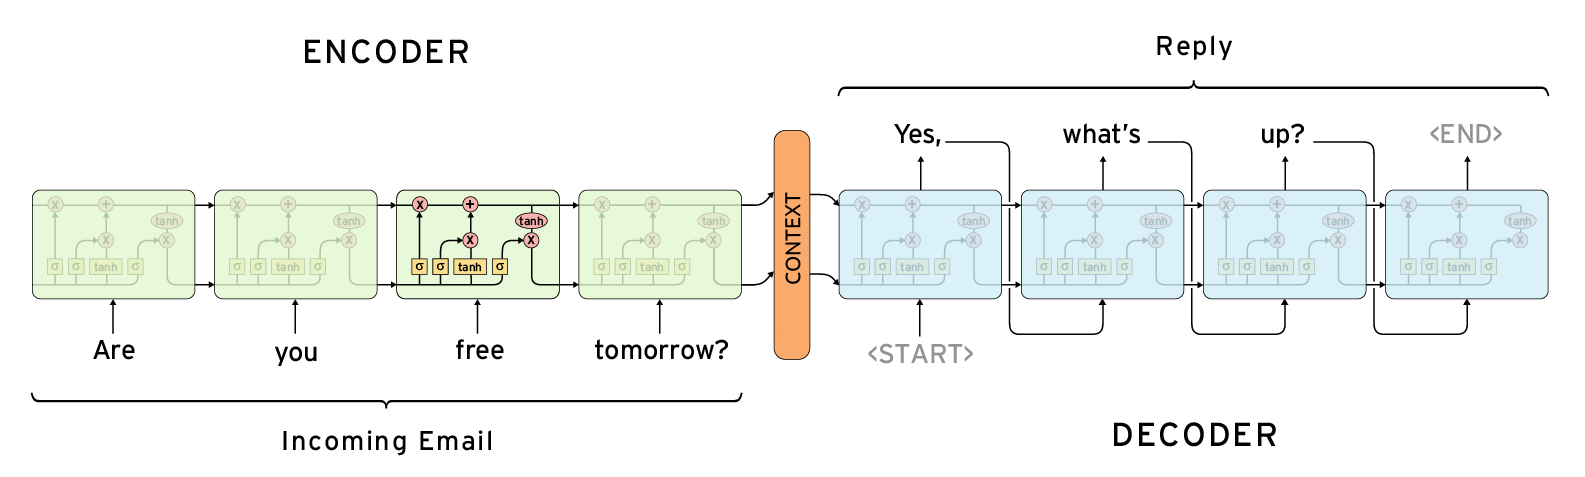

Модель чатбота. Генерация новых предложений.
На выходе encoder-а входная последовательность индексов преобразуется в вектор состояний context. Этот вектор подается на декодер.

Декодер на выходе должен преобразовать последовательность на входе encoder в последовательность выходе декодера (ответ) неопределенной длины. Поэтому модель называется — seq2seq. В общем случае, длина последовательности на выходе декодера не равна длине последовательности на входе encoder. Например, на входе вопрос, а на выходе ответ. Очевидно, что длины предложений будут совпадать далеко не всегда.

На этапе обучения длина выходной последовательности известна, поэтому обучать можно обычным способом, выровняв длины предложений добавлением 0-ей.

На вход декодировщику на первом такте подается специальный символ \<Start>, затем
на каждом такте подается сгенерированное в предыдущую итерацию слово. Генерация ответа продолжается до тех пор, пока не будет сгенерировано специальное слово
– маркер конца строки \<End>. Во время обучения в качестве сгенерированного символа на следующий такт передается целевой символ, а распределение на
предсказанных символах передается в функцию потерь.
Во время предсказания требуется найти наиболее вероятное предложение с точки зрения модели. 

Сделать это напрямую оказывается не очень корректно, так как модель позволяет вычислять только наилучшее слово при фиксированных предыдущих. 

Компромиссным решением между жадным выбором слов и полным перебором является Beam Search. При использовании этого метода на каждой итерации выбирается небольшое
количество лучших кандидатов, а остальные гипотезы отбрасываются.

##Создадим чат-бот ответов на вопросы.

##Инициализация необходимых библиотек.

In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model, get_file # удобный график для визуализации архитектуры модели
from sklearn.model_selection import train_test_split

import csv # импортируем модуль для удобной работы с файлами
import json
import logging
logging.disable(logging.WARNING)
import string

##Загрузка данных. База диалогов: Вопрос-ответ.

In [ ]:
def Load_data_from_udt3(max_word): # загружаем данные и формируем списки вопросов и ответов
    file_name = get_file(origin='http://dataudt.ru/datasets/Database_QARus.txt', fname='Database QARus.txt')
    questions = []
    answers = []
    with open(file_name, encoding='utf-8', newline='') as file:
        file_reader = csv.reader(file,  delimiter='\n') 
        for i, row in enumerate(file_reader):
            # формируем данные одна строка вопрос, вторая ответ
            if (i%2 == 0):
                quest_= row[0]
            else: 
                answer_ = row[0]
                # проверяем не превышает ли вопрос или ответ максимальное количество слов, если да то не заносим в базу эти данные
                if (len(answer_.split()) > max_word) or (len(quest_.split()) > max_word ): 
                    continue 
                else: # Добавим запись вопрос-ответ в соотвествующие списки
                    # сразу убираем ненужные символы '--', '-', '\n'
                    questions.append(quest_.replace('--','').replace('\n',' ')) 
                    # Сделаем теги-метки для начала и конца ответов 
                    answers.append('<START> ' + answer_.replace('-','').replace('\n',' ')  + ' <END>')
            
    print('Данные сформированы!') 
    return  questions, answers  

In [ ]:
max_word = 15 #зададим максимальную длину вопроса и ответа
questions, answers = Load_data_from_udt3(max_word)

Данные сформированы!


Делим на обучающую и тестовую выборки.

In [ ]:
questions, questions_test, answers, answers_test = train_test_split(questions, answers, test_size=0.85, shuffle=True)

In [ ]:
num_strok = 0
print(f'Вопрос: {questions[num_strok]}')
print(f'Кол-во базы вопросов: {len(questions)}')
print(f'Кол-во базы вопросов на тестовой: {len(questions_test)}')
print(f'Ответ с тегами: {answers[num_strok]}')
print(f'Кол-во базы ответов: {len(answers)}')

Вопрос:  Урологическая помощь. 
Кол-во базы вопросов: 3848
Кол-во базы вопросов на тестовой: 21808
Ответ с тегами: <START>  молодец. иди еще постой у метро с листовками. <END>
Кол-во базы ответов: 3848


##Обработка данных.

Создадим токенайзер, с возможностью сохранения токенайзера в файл.
Это чрезвычайно важно, поскольку алгоритмы глубокого обучения и машинного обучения работают с числами.

In [ ]:
# Подключаем керасовский токенизатор и собираем словарь индексов
def Create_and_save_tokenizer(questions, # база вопросов
                              answers,   # база ответов
                              maxWordsCount = None, # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
                              save_flag = False,    # необходимость записи в файл
                              file_name_tokin = 'tokenizer_for_bot2.json' # файл в который будет сохранен токенайзер
                              ):
    
    tokenizer = Tokenizer(num_words=maxWordsCount, # максимальное количество слов, которые будет учитывать наш токенайзер
                        lower=True, # приводятся ли все символы к нижнему регситру
                        split=' ', # символ, по которому происходит разделение на слова (токены)
                        oov_token='unknown', # токен для неизвестных слов 
                        char_level=False, # являются ли токенами отдельные буквы
                        # filters='<>' # символы, которые он токенайзер будет фильтровать
                        )
    tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
    vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
    vocabularySize = len(vocabularyItems)+1 # размер словаря
    print(f'Фрагмент словаря : {vocabularyItems[:50]}')
    print(f'Размер словаря : {vocabularySize}')
    if save_flag:
        tokenizer_json = tokenizer.to_json()
        with open(file_name_tokin, 'w', encoding='utf-8') as f:
            f.write(json.dumps(tokenizer_json, ensure_ascii=False))
            print(f'Токинайзер для бота записан в : {file_name_tokin}')
    return tokenizer, vocabularySize

In [ ]:
#настройте путь для сохранения токенайзера на своем гугл-диске и задайте save_flag = True
file_name_tokin = '/content/drive/My Drive/datasets/seq2seq/tokenizer_for_bot2.json'
tokenizer, vocabularySize = Create_and_save_tokenizer(questions,answers,maxWordsCount = 10000, save_flag = True,file_name_tokin = file_name_tokin)

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('в', 4), ('на', 5), ('и', 6), ('не', 7), ('как', 8), ('что', 9), ('ответить', 10), ('затрудняюсь', 11), ('с', 12), ('а', 13), ('это', 14), ('можно', 15), ('у', 16), ('или', 17), ('ли', 18), ('если', 19), ('вы', 20), ('по', 21), ('для', 22), ('я', 23), ('кто', 24), ('где', 25), ('за', 26), ('есть', 27), ('из', 28), ('подскажите', 29), ('то', 30), ('какой', 31), ('почему', 32), ('http', 33), ('будет', 34), ('от', 35), ('нет', 36), ('к', 37), ('когда', 38), ('пожалуйста', 39), ('чем', 40), ('сколько', 41), ('помогите', 42), ('ru', 43), ('какие', 44), ('все', 45), ('1', 46), ('так', 47), ('мне', 48), ('но', 49), ('2', 50)]
Размер словаря : 18143
Токинайзер для бота записан в : /content/drive/My Drive/datasets/seq2seq/tokenizer_for_bot2.json


Далее нужно дополнить ввод. Причина заполнения входных и выходных данных заключается в том, что текстовые предложения могут быть разной длины, однако LSTM  ожидает входные экземпляры одинаковой длины. Поэтому нужно преобразовать наши предложения в векторы фиксированной длины. Один из способов сделать это-с помощью заполнения.

В дополнении для предложения определяется определенная длина. В нашем случае длина самого длинного предложения на входах и выходах будет использоваться для заполнения входных и выходных предложений соответственно. Для предложений, содержащих менее слов чем в самом длинном, в пустые индексы будут добавлены нули. 


In [ ]:
def Tokenized_data(data_token, tokenizer): # метод для токенизации данных
    # Устанавливаем закодированные входные данные
    tokenizedDatas = tokenizer.texts_to_sequences(data_token) # разбиваем текст вопросов на последовательности индексов
    maxLenData = max([ len(x) for x in tokenizedDatas]) # уточняем длину самого большого элемента последовательности
    # Делаем последовательности одной длины, заполняя нулями более короткие вопросы
    paddedDatas = pad_sequences(tokenizedDatas, maxlen=maxLenData, padding='post')
    # Предподготавливаем данные для входа в сеть
    dataForInput = np.array(paddedDatas) # переводим в numpy массив
    return dataForInput, maxLenData

In [ ]:
# метод для токенизации данных, с переводом в one hot encoding при flag_OHE=True
def Tokenized_data_OHE(answers,tokenizer,vocabularySize, flag_OHE=False): 

    tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
    for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
        tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
    # Делаем последовательности одной длины, заполняя нулями более короткие ответы
    paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')
    if flag_OHE:
        oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
        decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy
    else:
        decoderForOutput = np.array(paddedAnswers) # и сохраняем в виде массива numpy
        decoderForOutput = np.expand_dims(decoderForOutput,-1) # добавляем  размерность
    return decoderForOutput

In [ ]:
encoderForInput, maxLenQuestions = Tokenized_data(questions, tokenizer)
decoderForInput, maxLenAnswers = Tokenized_data(answers, tokenizer)

In [ ]:
decoderForOutput = Tokenized_data_OHE(answers, tokenizer, vocabularySize, flag_OHE=False)

Выведем статистические данные и фрагменты токенизированных данных.

In [ ]:
num_strok = 100 # номер примера для вывода
print('Пример оригинального вопроса на вход : ',questions[num_strok]) 
print('Пример кодированного вопроса на вход : ', encoderForInput[num_strok]) 
print('Размеры закодированного массива вопросов на вход : ', encoderForInput.shape) 
print('Установленная длина вопросов на вход : ', maxLenQuestions)

print('\nПример оригинального ответа на вход: ', answers[num_strok]) 
print('Пример раскодированного ответа на вход : ', decoderForInput[num_strok]) 
print('Размеры раскодированного массива ответов на вход : ', decoderForInput.shape) 
print('Установленная длина ответов на вход : ', maxLenAnswers)

print('\nПример раскодированного ответа на вход : ', decoderForInput[num_strok][:21])  
print('Пример раскодированного ответа на выход : ', decoderForOutput[num_strok][:21]) 
print('Размеры раскодированного массива ответов на выход : ', decoderForOutput.shape)
print('Установленная длина вопросов на выход : ', maxLenAnswers) 

Пример оригинального вопроса на вход :   по какому номеру проще связаться с оператором Мегафон Уральского региона? 
Пример кодированного вопроса на вход :  [  21 1758 2686 1296 5322   12 2687 5323 5324 5325    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход :  (3848, 49)
Установленная длина вопросов на вход :  49

Пример оригинального ответа на вход:  <START>  500 <END>
Пример раскодированного ответа на вход :  [   2 1000    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Размеры раскодированного массива ответов на вход :  (3848, 44)
Установленная длина ответов на вход :  44

Пример раскодированного ответа на вход :  [   2 1000    3

##Создадим модели нейронной сети.

Создаем кодер и декодер. Входным сигналом для кодера будет вопрос, а выходным-скрытое состояние и состояние ячейки LSTM.

Следующим шагом является определение декодера. Декодер будет иметь два входа: скрытое состояние и состояние ячейки от кодера и входное предложение, которое на самом деле будет выходным предложением с маркером, добавленным в начале.

Наконец, выход из декодера LSTM пропускается через полносвязный слой для прогнозирования выходов декодера, ответа.

Далее компилируем модель, используя оптимайзер RMSprop, он в моделях seq2seq, показывает лучший результат. В качестве функции ошибки используем 
'sparse_categorical_crossentropy', что в свою очередь позволит определить вероятность использования слова и обойтись без ипсользования преобразования OHE.

In [ ]:
def Create_Model_seq2seq(vocabularySize, embedding_size = 200, hidden_size = 200):
    # Первый входной слой, энкодер, выходной слой
    encoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет encoderForInput)
    # Эти данные проходят через слой Embedding (длина словаря, размерность) 
    encoderEmbedding = Embedding(vocabularySize, embedding_size,  mask_zero=True) (encoderInputs)
    # Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
    # Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
    encoderOutputs, state_h , state_c = LSTM(hidden_size, return_state=True)(encoderEmbedding)
    encoderStates = [state_h, state_c]

    # Второй входной слой, декодер, выходной слой
    decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
    # Эти данные проходят через слой Embedding (длина словаря, размерность) 
    # mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
    decoderEmbedding = Embedding(vocabularySize, embedding_size, mask_zero=True) (decoderInputs) 
    # Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
    decoderLSTM = LSTM(hidden_size, return_state=True, return_sequences=True)
    decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
    # И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
    decoderDense = Dense(vocabularySize, activation='softmax') 
    output = decoderDense (decoderOutputs)

    # Собираем модель нейросети
    model = Model([encoderInputs, decoderInputs], output)
    # Оптимизатором , который мы использовали, является RMSprop, он используется в моделях с рекуррентными слоями.
    # В качестве функции ошибки используем 'sparse_categorical_crossentropy', что в свою очередь позволит определить 
    # вероятность использования слова и обойтись без ипсользования преобразования OHE.
    model.compile( optimizer=RMSprop(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'] )
    
    return model

In [ ]:
hidden_size = 200
embedding_size = 200
# Создадим экземпляр модели
modelseq2seq = Create_Model_seq2seq(vocabularySize,embedding_size,hidden_size)

Визуализируем модель.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    3628600     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    3628600     input_4[0][0]                    
____________________________________________________________________________________________

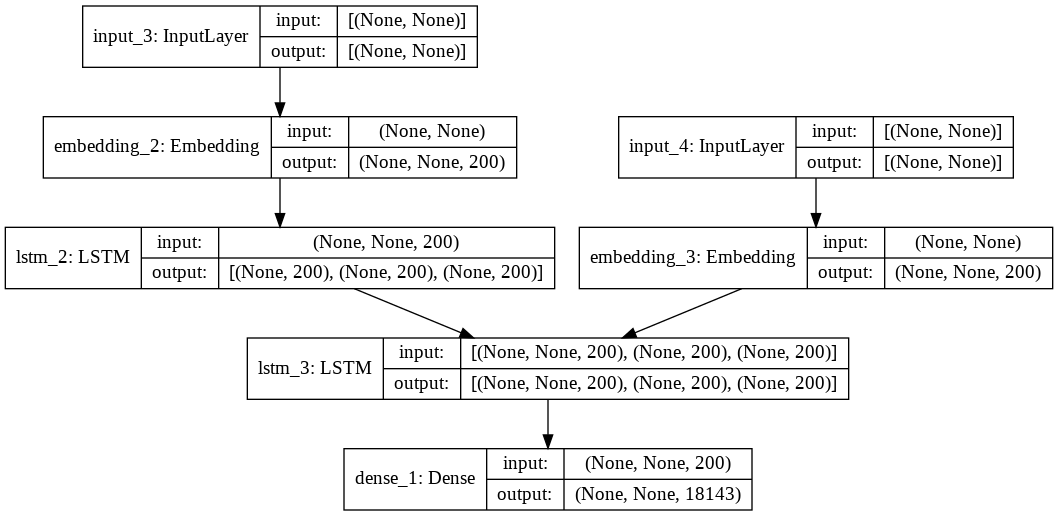

In [ ]:
print(modelseq2seq.summary(),'\n') # выведем на экран информацию о построенной модели нейросети
plot_model(modelseq2seq, to_file='model.png', show_shapes=True) # и построим график для визуализации слоев и связей между ними

Из выходных данных можно увидеть, что у нас есть два типа входных данных. input_1 – это входной заполнитель для кодера, который встроен и проходит через слой lstm_2 , который в основном является кодером LSTM. Существует три выхода из слоя lstm_2 : выход, скрытый слой и состояние ячейки. Однако в декодер передаются только состояние ячейки и скрытое состояние.

Здесь слой lstm_3 является декодером LSTM. input_2 содержит выходные предложения с маркерами. input_2 также передается через слой встраивания и используется в качестве входных данных для декодера LSTM, lstm_3 . 

Наконец, выход из декодера LSTM пропускается через полносвязный слой для получения прогнозов.

Следующим шагом является обучение модели с помощью метода fit() :

In [ ]:
# Запустим обучение
modelseq2seq.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
97/97 [==============================] - 25s 67ms/step - loss: 0.9373 - sparse_categorical_accuracy: 0.2290 - val_loss: 0.8424 - val_sparse_categorical_accuracy: 0.3107
Epoch 2/50
97/97 [==============================] - 11s 118ms/step - loss: 0.7553 - sparse_categorical_accuracy: 0.3548 - val_loss: 0.8060 - val_sparse_categorical_accuracy: 0.3687
Epoch 3/50
97/97 [==============================] - 11s 115ms/step - loss: 0.7297 - sparse_categorical_accuracy: 0.3774 - val_loss: 0.8013 - val_sparse_categorical_accuracy: 0.3702
Epoch 4/50
97/97 [==============================] - 11s 114ms/step - loss: 0.7151 - sparse_categorical_accuracy: 0.3864 - val_loss: 0.7972 - val_sparse_categorical_accuracy: 0.3775
Epoch 5/50
97/97 [==============================] - 11s 113ms/step - loss: 0.7034 - sparse_categorical_accuracy: 0.3966 - val_loss: 0.7984 - val_sparse_categorical_accuracy: 0.3700
Epoch 6/50
97/97 [==============================] - 12s 120ms/step - loss: 0.6925 - sparse_categ

In [ ]:
modelseq2seq.save('/content/drive/My Drive/datasets/seq2seq/my_bot_modelseq2seq2.h5') # Модель обучена с указанием товара в начале строки отзыва

In [ ]:
modelseq2seq = load_model('/content/drive/My Drive/datasets/seq2seq/my_bot_modelseq2seq2.h5')

In [ ]:
# Устанавливаем связи между слоями рабочей модели и предобученной
def loadInferenceModels(model,hidden_size = 200):
    encoderInputs = model.input[0]   # входом энкодера рабочей модели будет первый инпут предобученной модели(input_1)
    encoderEmbedding = model.layers[2] # связываем эмбединг слои(model.layers[2] это embedding_1)
    # вытягиваем аутпуты из первого LSTM слоя обуч.модели и даем энкодеру(lstm_1)
    encoderOutputs, state_h_enc, state_c_enc = model.layers[4].output 
    encoderStates = [state_h_enc, state_c_enc] # ложим забранные состояния в состояния энкодера
    encoderModel = Model(encoderInputs, encoderStates) # формируем модель

    decoderInputs1 = model.input[1]   # входом декодера рабочей модели будет второй инпут предобученной модели(input_2)
    decoderStateInput_h = Input(shape=(hidden_size ,)) # обозначим размерность для входного слоя с состоянием state_h
    decoderStateInput_c = Input(shape=(hidden_size ,)) # обозначим размерность для входного слоя с состоянием state_c

    decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

    decoderEmbedding = model.layers[3] # связываем эмбединг слои(model.layers[3] это embedding_2)
    decoderLSTM = model.layers[5] # связываем LSTM слои(model.layers[5] это lstm_2)
    decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding.output, initial_state=decoderStatesInputs)
    decoderStates = [state_h, state_c] # LSTM даст нам новые состояния

    decoderDense = model.layers[6] # связываем полносвязные слои(model.layers[6] это dense_1)
    decoderOutputs = decoderDense(decoderOutputs) # выход с LSTM мы пропустим через полносвязный слой с софтмаксом

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
    decoderModel = Model([decoderInputs1] + decoderStatesInputs, [decoderOutputs] + decoderStates)
    return encoderModel , decoderModel

# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    try:
       tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список
    except KeyError:
       tokensList.append(tokenizer.word_index['unknown'])
    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
# Устанавливаем окончательные настройки и запускаем модель
def show_predict_seq2seq(encModel, decModel, list_test):
    for str_for_inf in list_test: # задаем количество вопросов, и на каждой итерации в этом диапазоне:
        # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом       
        statesValues = encModel.predict(strToTokens(str_for_inf))
        # Создаём пустой массив размером (1, 1)
        emptyTargetSeq = np.zeros((1, 1)) 
        # положим в пустую последовательность начальное слово 'start' в виде индекса   
        emptyTargetSeq[0, 0] = tokenizer.word_index['start'] 
        stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
        decodedTranslation = '' # здесь будет собираться генерируемый ответ
        while not stopCondition : # пока не сработало стоп-условие
            # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
            # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
            decOutputs, h, c = decModel.predict([emptyTargetSeq] + statesValues)
            
            #argmax пробежит по вектору decOutputs, найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
            sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси. Получили индекс предсказанного слова.
            sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
            for word , index in tokenizer.word_index.items():
                if (sampledWordIndex == index) and (1 < index): # если индекс выбранного слова соответствует какому-то индексу из словаря
                    decodedTranslation += f' {word}' # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
                    sampledWord = word # выбранное слово фиксируем в переменную sampledWord
            
            # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
            if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
                stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

            emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
            emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
            statesValues = [h, c] # и состояния, обновленные декодером
            # и продолжаем цикл с обновленными параметрами
        str_for_inf_answer = decodedTranslation[:-3] # без маркера <end>
        print("Вопрос: ", str_for_inf) # выводим отзыв-покупателя, как входное значение
        print("Ответ : ", str_for_inf_answer) # выводим ответ сгенерированный декодером

In [ ]:
# запускаем функцию для построения модели кодера и декодера, для предобученной модели
encModel, decModel = loadInferenceModels(modelseq2seq, hidden_size) 

In [ ]:
list_test = [] 
list_test.extend(questions_test[40:60]) #заведем примеры вопросов из тестовой выборки 
#list_test.extend(questions[20:40]) #заведем примеры вопросов из обучающей выборки

In [ ]:
show_predict_seq2seq(encModel, decModel, list_test)

Вопрос:   Духовенство и народ. Характер взаимоотношений. 
Ответ :   нет 
Вопрос:   Привет от Новороссии русскому народу 
Ответ :   затрудняюсь ответить 
Вопрос:   Подскажите, маги, здоров ли кот, долго ли проживет?? ? род. 28.08.2013   
Ответ :   я бы года 
Вопрос:   Как можно узнать вечерние торги валюты? 
Ответ :   это бы это то что нравится 
Вопрос:   Почему ты ушёл и взял с собой маму? 
Ответ :   потому что что за такое 
Вопрос:   У этой прически есть название? 
Ответ :   это это очень хорошо 
Вопрос:   ЧТО ЗА КАНАЛ-МЕДЛЕННОЕ ТЕЛЕВИДЕНИЕ? 
Ответ :   затрудняюсь ответить 
Вопрос:   Можно ли в С++ индексировать битовое поле? Как? 
Ответ :   
Вопрос:   Помню слова "зумба" в песни которую танцуют или делают зарядку?   Как называется?
Ответ :   я тем их 
Вопрос:   Кто пробовал жвачки body fit? Какой результат? 
Ответ :   ну к от от http www 
Вопрос:   А ваши предчувствия вас часто обманывают?))) 
Ответ :   да я раз меньше 
Вопрос:   А вы ещё верите в Валеру? 
Ответ :   затрудняюсь ответ

##Библиотека Seq2seq
Это дополнение sequence to sequens обучения для библиотеки глубокого обучения python Keras. Используя библиотеку Seq2seq, можно строить и обучать последовательные нейронные сетевые модели Keras.

Seq2Seq содержит модульные и многоразовые слои, которые можно использовать как для создания собственных моделей seq2seq, так и встроенных моделей, работающих из коробки. Модели Seq2Seq могут быть скомпилированы так, как они есть, или добавлены в виде слоев к более крупной модели. Каждая модель Seq2Seq имеет 2 основных уровня : кодер и декодер. Как правило, кодер кодирует входную последовательность во внутреннее представление, называемое "контекстным вектором", которое используется декодером для генерации выходной последовательности. Длины входных и выходных последовательностей могут быть разными, так как между входными и выходными последовательностями нет явного отношения "один на один".

Простая модель Seq2Seq:

In [ ]:
import seq2seq
from seq2seq.models import SimpleSeq2Seq

model = SimpleSeq2Seq(input_dim=5, hidden_dim=10, output_length=8, output_dim=8)
model.compile(loss='mse', optimizer='rmsprop')

Глубокие модели Seq2Seq, построим 6-слойную глубокую модель Seq2Seq (3 слоя для кодирования, 3 слоя для декодирования). 

Пример:

In [ ]:
import seq2seq
from seq2seq.models import SimpleSeq2Seq

model = SimpleSeq2Seq(input_dim=5, hidden_dim=10, output_length=8, output_dim=8, depth=3)
model.compile(loss='mse', optimizer='rmsprop')

Можно указать различные глубины для кодера и декодера. В этом случае  глубина задается как кортеж, (4, 5). Это означает, что ваш кодер будет иметь глубину 4 слоя, в то время как ваш декодер будет иметь глубину 5 слоев. И ваша модель будет иметь общую глубину 4 + 5 = 9.  
Пример:

In [ ]:
import seq2seq
from seq2seq.models import SimpleSeq2Seq

model = SimpleSeq2Seq(input_dim=5, hidden_dim=10, output_length=8, output_dim=20, depth=(4, 5))
model.compile(loss='mse', optimizer='rmsprop')

Расширенные модели Seq2Seq:

SimpleSeq2Seq модель, является очень минималистичной моделью. В фактической реализации Seq2Seq, описанных в примерах ранее, скрытое состояние кодера передается декодеру. Кроме того, выход декодера на каждом временном шаге становится входом декодера на следующем временном шаге. Расширенная модель Seq2Seq позволяет, скрытое состояние распространить по всему стеку LSTM. Встроенная модель, которая делает все это из коробки.

Пример:

In [ ]:
import seq2seq
from seq2seq.models import Seq2Seq

model = Seq2Seq(batch_input_shape=(16, 7, 5), hidden_dim=10, output_length=8, output_dim=20, depth=4)
model.compile(loss='mse', optimizer='rmsprop')

Peeky Seq2seq модель:

Построим модель, где декодер получает "взгляд" на вектор контекста на каждом временном шаге. Для этого надо добавить аргумент peek=True.

Пример:

In [ ]:
import seq2seq
from seq2seq.models import Seq2Seq

model = Seq2Seq(batch_input_shape=(16, 7, 5), hidden_dim=10, output_length=8, output_dim=20, depth=4, peek=True)
model.compile(loss='mse', optimizer='rmsprop')

Модель Seq2seq с вниманием:

В моделях, описанных выше, нет никакого соответствия между элементами входной последовательности и элементами выходной последовательности. Но например для машинного перевода обучение  выравнивание между входными и выходными последовательностями повышает производительность. Фреймворк Seq2seq включает в себя готовую модель с вниманием, в которой это реализовано. Обратите внимание, что в модели внимания нет пропогации скрытого состояния, и по умолчанию используется двунаправленный кодер LSTM.

Пример:

In [ ]:
import seq2seq
from seq2seq.models import AttentionSeq2Seq

model = AttentionSeq2Seq(input_dim=5, input_length=7, hidden_dim=10, output_length=8, output_dim=20, depth=4)
model.compile(loss='mse', optimizer='rmsprop')

В модели внимания  не нужно указывать размер выборок, так как в ней нет статических скрытых состояний. Но это можно сделать, если строить модель Seq2seq с сохранением состояния. Тогда, необходимо установить аргумент bidirectional=False если вы не хотите использовать двунаправленный кодер.

##Механизмы внимания (Attention)
Механизмы внимания — это подход в машинном обучении, заключающийся в выделении части входных данных (регионов изображений, фрагментов текста) для более
детальной обработки.

Механизмы внимания  часто используются в нейросетевом машинном переводе. Проблемой обычных Seq2Seq моделей является необходимость
сжать всю информацию в векторе представления. Эта проблема становится особенно
существенной при переводе длинных последовательностей. 
Seq2Seq с вниманием значительно улучшает качество работы на длинных последовательностях. В качестве объекта внимания в таких моделях используются выходы
последнего слоя кодирующей части для каждого слова. В качестве ключа выбирается
выход последнего слоя декодирующей части. Для генерации слов вектор контекста
конкатенируется с ключом и пропускается через еще один рекуррентный слой.

###Устройство слоя механизма внимания

Обобщенный механизм внимания в RNN
Слой механизма внимания представляет собой обычную, чаще всего однослойную, нейронную сеть на вход которой подаются ht,t=1 …m, а также вектор d в котором содержится некий контекст зависящий от конкретной задачи.

В случае Seq2seq сетей вектором d будет являться скрытое состояние di−1 предыдущей итерации декодера.

Выходом данного слоя будет является вектор s (англ. score) — оценки на основании которых на скрытое состояние hi будет "обращено внимание".

Далее для нормализации значений s используется softmax. Тогда  e=softmax(s)

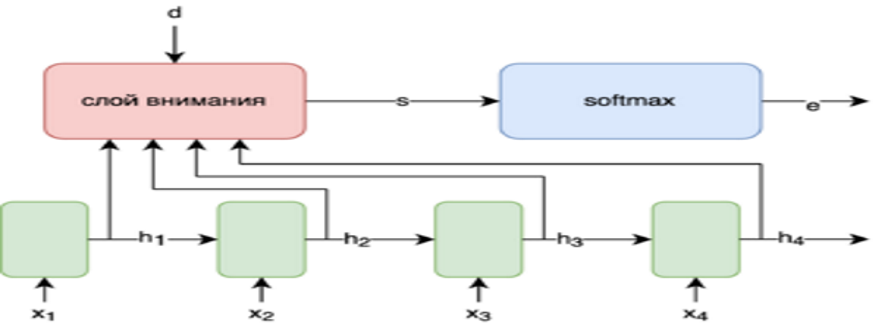

###Применение механизма внимания к базовой Seq2seq архитектуре.
При добавлении механизма в данную архитектуру между RNN Энкодером и Декодером слоя механизма внимания получится следующая схема:

Здесь xi,hi,di,yi имеют те же назначения, что и в варианте без механизма внимания.

Агрегатор скрытых состояний энкодера (желтый) — агрегирует в себе все вектора hi и возвращает всю последовательность векторов h=[h1,h2,h3,h4].

ci — вектор контекста на итерации i.

Блоки механизма внимания (красный) — принимает h и di−1, возвращает ci.

Блоки декодера (фиолетовый) — по сравнению с обычной Seq2seq сетью меняются входные данные. Теперь на итерации i на вход подается не yi−1, а конкатенация yi−1 и ci.

Таким образом при помощи механизма внимания достигается "фокусирование" декодера на определенных скрытых состояниях. В случаях машинного перевода эта возможность помогает декодеру предсказывать на какие скрытые состояния при исходных определенных словах на языке A необходимо обратить больше внимания при переводе данного слова на язык B. То есть на какие слова из исходного текста обратить внимание при переводе конкретного слова на язык назначения.

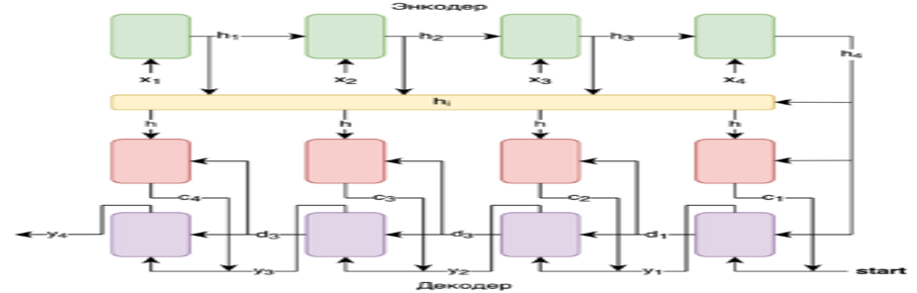

###Реализация Attention  в Keras из коробки.

В настоящее время механизм Attention не реализован в самом Keras. Но уже есть сторонние реализации, например attention-keras который можно установить с github. Тогда ваш код станет предельно простым:

In [ ]:
from attention_keras.layers.attention import AttentionLayer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

Предварительно обучив слой Attention,  можно
включить этот код в сеть как один из уровней и наслаждаться обучением основоной модели нейронной  сети. 
Данная реализация поддерживает функцию визуализации весов Attention. Обучив Attention можно получить матрицу, сигнализирующую, что по мнению сети особенно важно примерно такого вида:


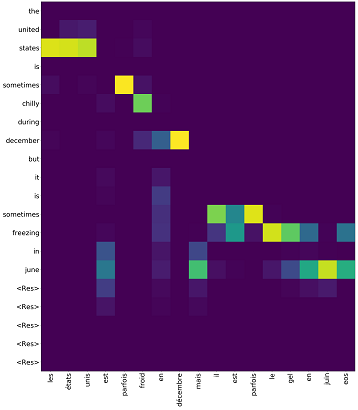

Реализация Attention в Keras на низком уровне

Чтобы немного глубже разобраться в теме, ниже подробно разберём реализацию Attention под капотом. 
Простейшая реализация механизма Attention в Keras занимает всего 3 строки:

In [ ]:
inputs = Input(shape=(input_dims,))
attention_probs = Dense(input_dims, activation='softmax', name='attention_probs')(inputs)
attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul'

В данном случае в первой строке декларируется слой Input, далее идёт полносвязный слой с функцией активации softmax с количеством нейронов равным количеству элементов в первом слое. Третий слой умножает результат полносвязного слоя на входные данные поэлементно.

У механизма Attention есть вариации. Мы рассмотрели простейший из них.

Подробный разобранный пример нейронного машинного перевода с вниманием, можно изучить по ссылке в списке дополнительной литературы.

##Литература
1. "Механизмы внимания в нейронных сетях." Полыковский Даниил Александрович. Москва-2017.http://www.machinelearning.ru/wiki/images/c/cd/2017_417_PolykovskyDA.pdf
2. Библиотека Seq2seq: https://github.com/farizrahman4u/seq2seq
3. Обучение от последовательности к последовательности с помощью нейронных сетей. https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf
4. Изучение представлений фраз с использованием кодера–декодера RNN для статистического машинного перевода. https://arxiv.org/pdf/1406.1078.pdf
5. Нейронный машинный перевод путем совместного обучения выравниванию и переводу. https://arxiv.org/pdf/1409.0473v6.pdf
6. NLP Sequence to sequence Network. https://towardsdatascience.com/nlp-sequence-to-sequence-networks-part-2-seq2seq-model-encoderdecoder-model-6c22e29fd7e1
7. LSTM - сети долгой краткосрочной памяти. https://habr.com/ru/company/wunderfund/blog/331310/
8. Нейронный машинный перевод с вниманием. https://www.tensorflow.org/text/tutorials/nmt_with_attention


